###  Pneumonia Detection


### Import the required libraries

In [2]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, AveragePooling2D, Flatten
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt  
import os 
import numpy as np
import cv2 
%matplotlib inline
import skimage
from skimage.transform import resize
from sklearn.linear_model import LogisticRegression
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [3]:
mainDIR = os.listdir('../ml/chest_xray_small')
print(mainDIR)

['test', 'train']


### Load the chest x-ray dataset

In [4]:
train_folder= '../ml/chest_xray_small/train/'
test_folder = '../ml/chest_xray_small/test/'

In [86]:
pneumonia = os.listdir(train_folder + "PNEUMONIA")
normal = os.listdir(test_folder + "NORMAL")

### Print some sample images after resizing them to 162,128

(Left) - No Pneumonia Vs (Right) - Pneumonia
-------------------------------------------------------------------------------------------------------------


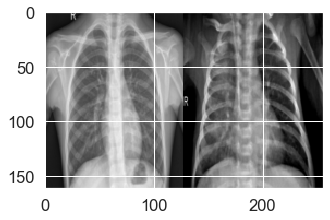

(Left) - No Pneumonia Vs (Right) - Pneumonia
-------------------------------------------------------------------------------------------------------------


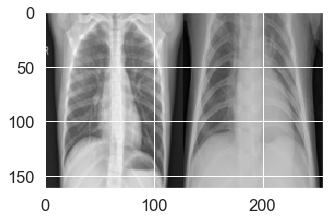

(Left) - No Pneumonia Vs (Right) - Pneumonia
-------------------------------------------------------------------------------------------------------------


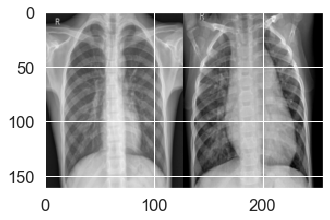

(Left) - No Pneumonia Vs (Right) - Pneumonia
-------------------------------------------------------------------------------------------------------------


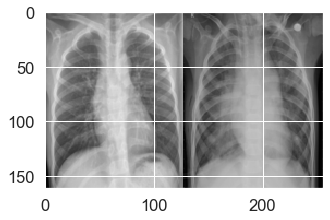

(Left) - No Pneumonia Vs (Right) - Pneumonia
-------------------------------------------------------------------------------------------------------------


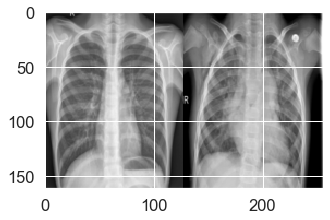

In [87]:
def plotter(j):
    imagep = cv2.imread(train_folder+"PNEUMONIA/"+pneumonia[j])
    imagep = skimage.transform.resize(imagep, (162, 128,3) , mode = 'reflect')
    imagen = cv2.imread(test_folder+"NORMAL/"+normal[j])
    imagen = skimage.transform.resize(imagen, (162, 128,3))
    pair = np.concatenate((imagen, imagep), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(5,5))
    plt.imshow(pair)
    plt.show()
for j in range(0,5):
    plotter(j)

### Convert the images to grayscale and into a vector representation

In [88]:
labels = ['PNEUMONIA', 'NORMAL']
img_height = 162
img_width = 128
def get_images(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_height, img_width))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### Training data set is from the small data set and the test data set is from the original data set

In [89]:
train = get_images('../ml/chest_xray_small/train/')
test = get_images('../ml/chest_xray_small/test/')

In [90]:
X_train = []
y_train = []
X_test =[]
y_test = []

for image, label in train:
    X_train.append(image)
    y_train.append(label)

for imaget, labelt in test:
    X_test.append(imaget)
    y_test.append(labelt)

In [91]:
# for logistic regression
X_trainl = np.array(X_train).reshape(-1,img_height,img_width)
X_testl = np.array(X_test)

In [92]:
# Reshape the training and test examples 
X_train_flatten = X_trainl.reshape(X_trainl.shape[0], -1)   # The "-1" makes reshape flatten the remaining dimensions
X_test_flatten = X_testl.reshape(X_testl.shape[0], -1)

# Standardize data to have feature values between 0 and 1.
X_train_flatten = X_train_flatten/255.
X_test_flatten = X_test_flatten/255.

print ("train_x's shape: " + str(X_train_flatten.shape))
print ("test_x's shape: " + str(X_test_flatten.shape))

train_x's shape: (229, 20736)
test_x's shape: (624, 20736)


### Train a logistic regression model to perform the classification task.

In [93]:
lr = LogisticRegression(random_state = 20, max_iter=500, verbose = 1)
lr1 = lr.fit(X_train_flatten, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


### Plotting the confusion matrix and classification report for logistic regression classification model
#### For evaluating the performance of the model

The confusion matrix gives us the total number of:
1. True Positive(TP): 325 correct predictions of pneumonia images.
2. False Negative(FN): 65 pneumonia images falsely identified as normal.
3. False Positive(FP): 56 normal images incorrectly identified as pneumonia images.
4. True Negative(TN): 178 normal images correctly identified.

The overall F1-Score: 0.806 

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       390
           1       0.73      0.76      0.75       234

    accuracy                           0.81       624
   macro avg       0.79      0.80      0.79       624
weighted avg       0.81      0.81      0.81       624



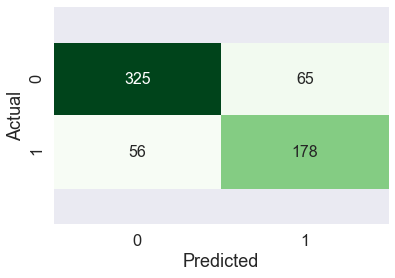

F1-Score: 
0.8067873137067763


In [94]:
predl = lr1.predict(X_test_flatten)
cm = confusion_matrix(y_test, predl)
print(classification_report(y_test,predl))
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("F1-Score: ")
print(f1_score(y_test, predl, average = 'weighted'))

### Train a convolutional neural network model to recognise pneumonia in these images using Le-Net5 model architecture

In [95]:
# resize training data for deep learning 
X_train = np.array(X_train).reshape(-1, img_height, img_width, 1)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(229, 162, 128, 1)
(229,)


In [96]:
# resize testing data for deep learning 
X_test = np.array(X_test).reshape(-1, img_height, img_width, 1)
y_test = np.array(y_test)

### Balancing the imabalanced classes using Random Over Sampler
Using the Over Sampler as the accuracy with Under Sampling was much lower.

In [97]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainSampl = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testSampl = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_train_Flatten = X_train.reshape(X_train.shape[0], X_trainSampl)
X_test_Flatten = X_test.reshape(X_test.shape[0], X_testSampl)
Y_train = y_train
Y_test = y_test
ros = RandomOverSampler()

X_train_sampled, Y_train_sampled = ros.fit_sample(X_train_Flatten, Y_train)
X_test_sampled, Y_test_sampled = ros.fit_sample(X_test_Flatten, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

# convert class vectors to binary class matrices
Y_trainBin = keras.utils.to_categorical(Y_train_sampled, num_classes = 2)
Y_testBin = keras.utils.to_categorical(Y_test_sampled, num_classes = 2)
# Make Data 2D again
for i in range(len(X_train_sampled)):
    height, width, channels = 162,128,1
    X_train_Reshaped = X_train_sampled.reshape(len(X_train_sampled),height,width,channels)
for i in range(len(X_test_sampled)):
    height, width, channels = 162,128,1
    X_test_Reshaped = X_test_sampled.reshape(len(X_test_sampled),height,width,channels)


X_train_Reshaped = X_train_Reshaped / 255
X_test_Reshaped= X_test_Reshaped / 255

In [98]:
# normalizing the training the test
X_train = X_train / 255
X_test = X_test / 255

In [99]:
YTrain = y_train

In [100]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [101]:
# let's build the CNN model

cnn = Sequential()

#Convolution
cnn.add(Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(162,128,1)))

#Pooling
cnn.add(AveragePooling2D(pool_size = (2,2) , strides = 2))

# 2nd Convolution
cnn.add(Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'))

# 2nd Pooling layer
cnn.add(AveragePooling2D(pool_size = (2,2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers

cnn.add(Dense(units=120, activation='tanh'))

cnn.add(Dense(units=84, activation='tanh'))

cnn.add(Dense(units=2, activation = 'softmax'))


# Compile the Neural network
cnn.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [102]:
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 158, 124, 6)       156       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 79, 62, 6)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 75, 58, 16)        2416      
_________________________________________________________________
average_pooling2d_12 (Averag (None, 37, 29, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 17168)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 120)               2060280   
_________________________________________________________________
dense_17 (Dense)             (None, 84)               

In [103]:
checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', mode = 'min', verbose=1, save_best_only=True)

In [104]:
history = cnn.fit(X_train, y_train, batch_size = 16, validation_split = 0.2 ,callbacks=[checkpoint] ,epochs=10)

Train on 183 samples, validate on 46 samples
Epoch 1/10
183/183 [==============================] - 4s 21ms/step - loss: 1.6413 - accuracy: 0.5301 - val_loss: 0.4375 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.43752, saving model to bestmodel.hdf5
Epoch 2/10
183/183 [==============================] - 3s 15ms/step - loss: 0.6738 - accuracy: 0.6120 - val_loss: 0.3281 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.43752 to 0.32815, saving model to bestmodel.hdf5
Epoch 3/10
183/183 [==============================] - 3s 16ms/step - loss: 0.6544 - accuracy: 0.5847 - val_loss: 0.5764 - val_accuracy: 0.9565

Epoch 00003: val_loss did not improve from 0.32815
Epoch 4/10
183/183 [==============================] - 3s 15ms/step - loss: 0.5676 - accuracy: 0.7869 - val_loss: 0.4208 - val_accuracy: 0.9565

Epoch 00004: val_loss did not improve from 0.32815
Epoch 5/10
183/183 [==============================] - 3s 14ms/step - loss: 0.4093 - accuracy: 0.9016 - val_

### Visualizing the training of the CNN model based on Accuracy, Loss, Validation Accuracy and Validation Loss 
We can see in the graphs below that the overall validation accuracy increases and the overall validation loss can be seen to be decreasing over the number of epochs. This means that model built is learning and working fine.

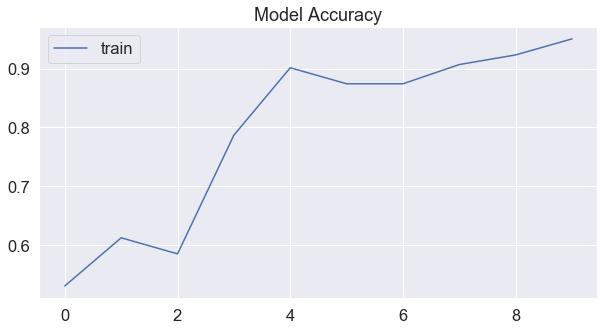

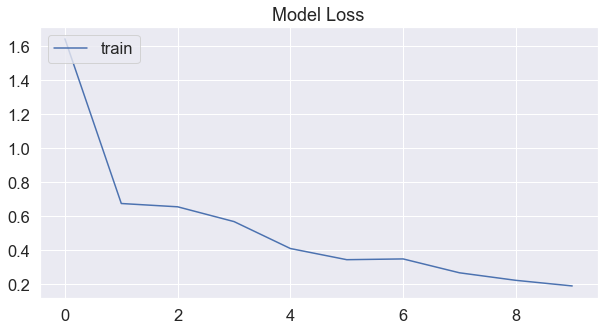

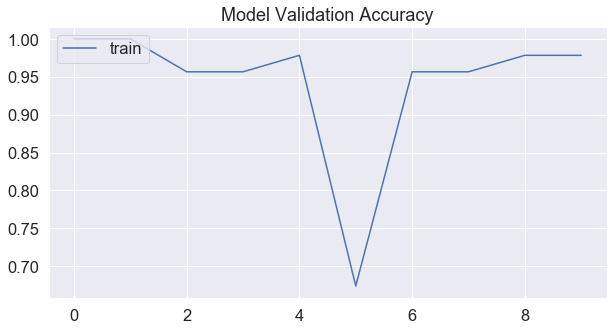

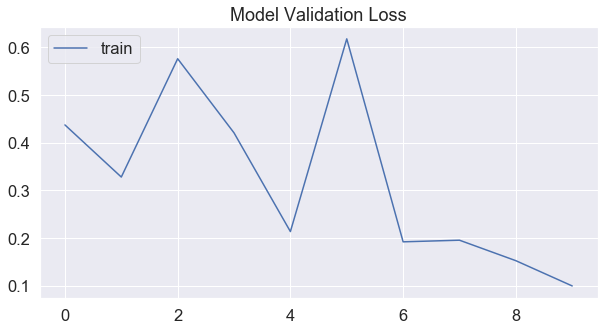

In [105]:
plt.figure(figsize=(10, 5))
plt.plot(history.epoch, history.history['accuracy'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.epoch, history.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()


### Plotting the confusion matrix and classification report for Le-Net5 CNN classification model
#### For evaluating the performance of the model

The confusion matrix gives us the total number of:
1. True Positive(TP): 273 correct predictions of pneumonia images.
2. False Negative(FN): 117 pneumonia images falsely identified as normal.
3. False Positive(FP): 30 normal images incorrectly identified as pneumonia images.
4. True Negative(TN): 204 normal images correctly identified.

The overall F1-Score: 0.768

              precision    recall  f1-score   support

           0       0.90      0.70      0.79       390
           1       0.64      0.87      0.74       234

    accuracy                           0.76       624
   macro avg       0.77      0.79      0.76       624
weighted avg       0.80      0.76      0.77       624



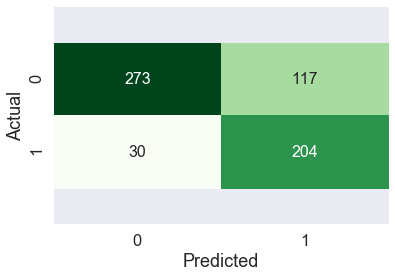

F1-Score: 
0.7680999180999181


In [106]:
pred = cnn.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)
print(classification_report(y_true,pred))
cm = confusion_matrix(y_true, pred)
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("F1-Score: ")
print(f1_score(y_true, pred, average='weighted'))

### Train a convolutional neural network model to recognise pneumonia in these images using Le-Net5 model architecture and handling the class imbalance in the dataset.

In [107]:
#class_weights = compute_class_weight('balanced', np.unique(YTrain), YTrain)
from sklearn.utils.class_weight import compute_class_weight

class_weight1 = compute_class_weight('balanced', np.unique(YTrain), YTrain)
print("Old Class Weights: ",class_weight1)

class_weight2 = compute_class_weight('balanced', np.unique(Y_train_sampled), Y_train_sampled)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [1.50657895 0.74836601]
New Class Weights:  [1. 1.]


In [108]:
# let's build the CNN model

balanced_cnn = Sequential()

#Convolution
balanced_cnn.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape= (162,128,1)))

#Pooling
balanced_cnn.add(AveragePooling2D(pool_size = (2,2) , strides = 2))

# 2nd Convolution
balanced_cnn.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu' ))

# 2nd Pooling layer
balanced_cnn.add(AveragePooling2D(pool_size = (2,2)))

# Flatten the layer
balanced_cnn.add(Flatten())

# Fully Connected Layers

balanced_cnn.add(Dense(units=120, activation='relu'))

balanced_cnn.add(Dense(units=84, activation='relu'))

balanced_cnn.add(Dense(units=2, activation = 'softmax'))


# Compile the Neural network
adam = Adam(learning_rate=0.0001)
balanced_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [109]:
balanced_history = balanced_cnn.fit(X_train_Reshaped, Y_trainBin, batch_size = 32, validation_split = 0.2 , class_weight = class_weight2, callbacks=[checkpoint] ,epochs=10)

Train on 244 samples, validate on 62 samples
Epoch 1/10
244/244 [==============================] - 4s 16ms/step - loss: 0.7404 - accuracy: 0.6680 - val_loss: 0.6383 - val_accuracy: 0.9516

Epoch 00001: val_loss did not improve from 0.09963
Epoch 2/10
244/244 [==============================] - 3s 12ms/step - loss: 0.5902 - accuracy: 0.6598 - val_loss: 0.9572 - val_accuracy: 0.0161

Epoch 00002: val_loss did not improve from 0.09963
Epoch 3/10
244/244 [==============================] - 3s 12ms/step - loss: 0.4937 - accuracy: 0.8156 - val_loss: 1.0244 - val_accuracy: 0.2903

Epoch 00003: val_loss did not improve from 0.09963
Epoch 4/10
244/244 [==============================] - 3s 12ms/step - loss: 0.3744 - accuracy: 0.8770 - val_loss: 0.5812 - val_accuracy: 0.7903

Epoch 00004: val_loss did not improve from 0.09963
Epoch 5/10
244/244 [==============================] - 3s 12ms/step - loss: 0.2822 - accuracy: 0.9057 - val_loss: 0.3113 - val_accuracy: 0.8710

Epoch 00005: val_loss did not i

### Visualizing the training of the CNN model (after handling imbalance) based on Accuracy, Loss, Validation Accuracy and Validation Loss 
We can see in the graphs below that the overall validation accuracy increases. But the validation loss can be seen to be fluctuating (peaks/troughs) over the number of epochs. This might be due to overfitting.

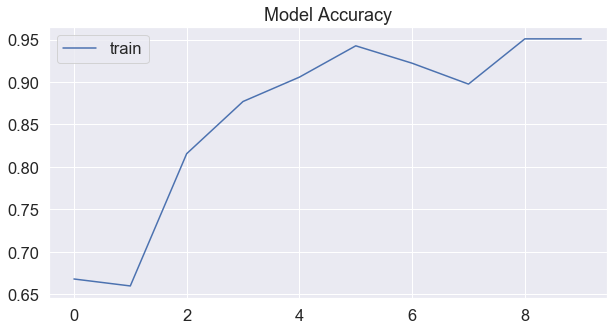

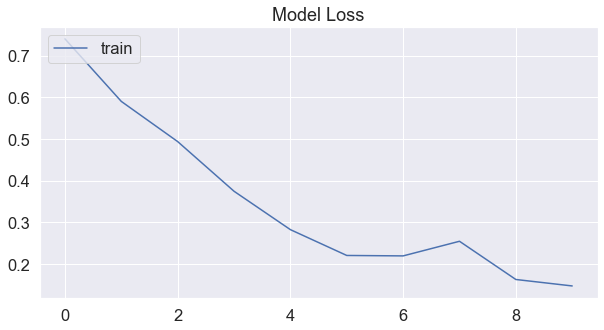

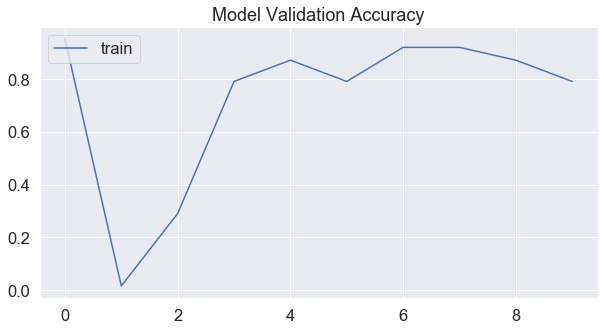

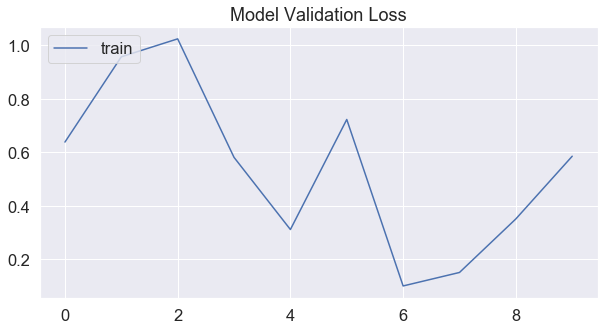

In [110]:
plt.figure(figsize=(10, 5))
plt.plot(balanced_history.epoch, balanced_history.history['accuracy'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(balanced_history.epoch, balanced_history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(balanced_history.epoch, balanced_history.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(balanced_history.epoch, balanced_history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

### Plotting the confusion matrix and classification report for Le-Net5 CNN classification model handling imbalance
#### For evaluating the performance of the model

The confusion matrix gives us the total number of:
1. True Positive(TP): 239 correct predictions of pneumonia images.
2. False Negative(FN): 151 pneumonia images falsely identified as normal.
3. False Positive(FP): 11 normal images incorrectly identified as pneumonia images.
4. True Negative(TN): 223 normal images correctly identified.

The overall F1-Score: 0.741

              precision    recall  f1-score   support

           0       0.96      0.61      0.75       390
           1       0.60      0.95      0.73       234

    accuracy                           0.74       624
   macro avg       0.78      0.78      0.74       624
weighted avg       0.82      0.74      0.74       624



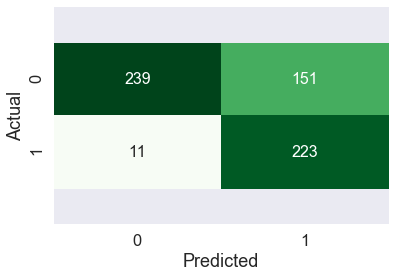

F1-Score: 
0.7418791118421052


In [111]:
pred = balanced_cnn.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)
print(classification_report(y_true,pred))
cm = confusion_matrix(y_true, pred)
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("F1-Score: ")
print(f1_score(y_true, pred, average='weighted'))

### Data Augmentation techniques to increase the dataset and train the model

In [112]:
augmentation = ImageDataGenerator(brightness_range=[1,2],zoom_range=0.2, fill_mode="nearest", validation_split=0.2)
generator = ImageDataGenerator()

In [113]:
print("Training Set")
train_gen = augmentation.flow_from_directory(directory=train_folder, target_size=(img_height, img_width),
    class_mode = 'categorical', color_mode ='grayscale', batch_size=16, subset='training', shuffle=False, seed=1)

print("Validation Set")
valid_gen = augmentation.flow_from_directory(directory=train_folder, target_size=(img_height, img_width),
    class_mode = 'categorical', color_mode ='grayscale',batch_size=16, subset='validation', shuffle=False, seed=1)


print("Test Set")
test_gen = generator.flow_from_directory(directory=test_folder, target_size=(img_height, img_width),
    class_mode = 'categorical', color_mode = 'grayscale', batch_size=1, shuffle=False, seed=20)

Training Set
Found 184 images belonging to 2 classes.
Validation Set
Found 45 images belonging to 2 classes.
Test Set
Found 624 images belonging to 2 classes.


In [114]:
aug_cnn = Sequential()

#Convolution
aug_cnn.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape= (162,128,1)))

#Pooling
aug_cnn.add(AveragePooling2D(pool_size = (2,2) , strides = 2))

# 2nd Convolution
aug_cnn.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu' ))

# 2nd Pooling layer
aug_cnn.add(AveragePooling2D(pool_size = (2,2)))

# Flatten the layer
aug_cnn.add(Flatten())

# Fully Connected Layers

aug_cnn.add(Dense(units=120, activation='relu'))

aug_cnn.add(Dense(units=84, activation='relu'))

aug_cnn.add(Dense(units=2, activation = 'softmax'))


# Compile the Neural network
adam = Adam(learning_rate=0.0001)
aug_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [115]:
checkpoint_aug = ModelCheckpoint('aug_cnn.hdf5', monitor='val_loss', mode = 'min', verbose=1, save_best_only=True)

In [116]:
history_aug = aug_cnn.fit_generator(train_gen,
                                  validation_data = valid_gen, steps_per_epoch = 16, validation_steps = 16, 
                                  callbacks = [checkpoint_aug],
                                  epochs=10, verbose=1)

Epoch 1/10
16/16 [==============================] - 11s 670ms/step - loss: 174.3193 - accuracy: 0.5726 - val_loss: 18.9879 - val_accuracy: 0.3112

Epoch 00001: val_loss improved from inf to 18.98787, saving model to aug_cnn.hdf5
Epoch 2/10
16/16 [==============================] - 10s 621ms/step - loss: 2.5176 - accuracy: 0.7944 - val_loss: 0.6651 - val_accuracy: 0.6805

Epoch 00002: val_loss improved from 18.98787 to 0.66509, saving model to aug_cnn.hdf5
Epoch 3/10
16/16 [==============================] - 10s 634ms/step - loss: 0.9798 - accuracy: 0.5708 - val_loss: 1.2930 - val_accuracy: 0.6429

Epoch 00003: val_loss did not improve from 0.66509
Epoch 4/10
16/16 [==============================] - 9s 557ms/step - loss: 0.5550 - accuracy: 0.7460 - val_loss: 0.0458 - val_accuracy: 0.6971

Epoch 00004: val_loss improved from 0.66509 to 0.04585, saving model to aug_cnn.hdf5
Epoch 5/10
16/16 [==============================] - 9s 586ms/step - loss: 0.6449 - accuracy: 0.8042 - val_loss: 0.4664

### Visualizing the training of the CNN model after data augmentation based on Accuracy, Loss, Validation Accuracy and Validation Loss 
We can see in the graphs below that the overall validation accuracy increases and the overall validation loss can be seen to be decreasing over the number of epochs. This means that model built is learning and working fine.

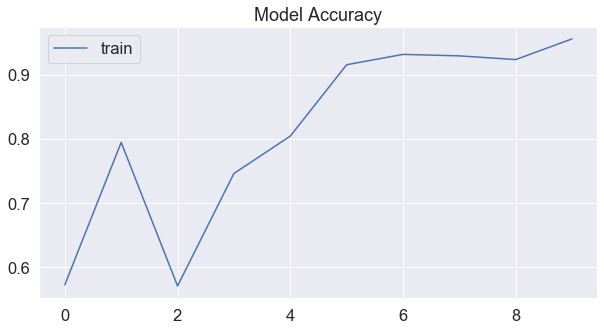

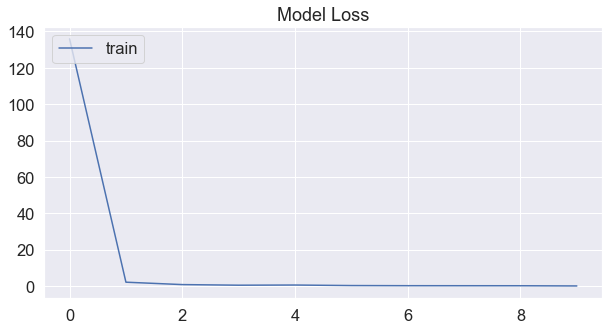

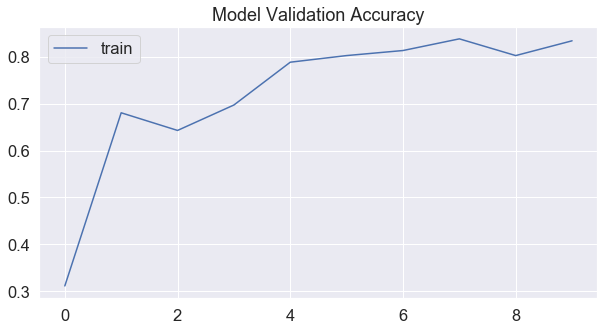

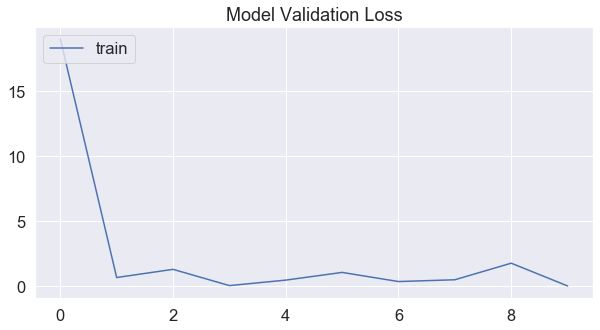

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(history_aug.epoch, history_aug.history['accuracy'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_aug.epoch, history_aug.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_aug.epoch, history_aug.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_aug.epoch, history_aug.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [118]:
no_steps = len(test_gen)
p = aug_cnn.predict_generator(test_gen, steps=no_steps, verbose=True)
pre = pd.DataFrame(p)
pre["filename"] = test_gen.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)

624/624 [==============================] - 8s 13ms/step


### Plotting the confusion matrix and classification report for Le-Net5 with data augmentation classification model handling imbalance
#### For evaluating the performance of the model

The confusion matrix gives us the total number of:
1. True Positive(TP): 230 correct predictions of pneumonia images.
2. False Negative(FN): 4 pneumonia images falsely identified as normal.
3. False Positive(FP): 193 normal images incorrectly identified as pneumonia images.
4. True Negative(TN): 197 normal images correctly identified.

The overall F1-Score: 0.679

              precision    recall  f1-score   support

           0       0.54      0.98      0.70       234
           1       0.98      0.51      0.67       390

    accuracy                           0.68       624
   macro avg       0.76      0.74      0.68       624
weighted avg       0.82      0.68      0.68       624



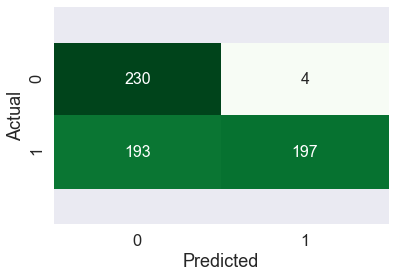

F1-Score: 
0.6792237442922374


In [120]:
print(classification_report(pre['label'],pre['pre']))
cm = confusion_matrix(pre['label'],pre['pre'])
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("F1-Score: ")
print(f1_score(pre['label'],pre['pre'], average='weighted'))

### Train the model using pre-trained VGG16 model

In [5]:
conv_vgg = VGG16(input_shape = (162, 128,3) , weights = 'imagenet', include_top = False)  

In [6]:
print(conv_vgg.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0     

In [7]:
# unfreezing the first convolutional layer
for layer in conv_vgg.layers[2:]:
    layer.trainable = False

In [8]:
# Check the trainable status of the individual layers
for layer in conv_vgg.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000242E23DF5C8> False
<keras.layers.convolutional.Conv2D object at 0x00000242E15A09C8> True
<keras.layers.convolutional.Conv2D object at 0x00000242D49E4308> False
<keras.layers.pooling.MaxPooling2D object at 0x00000242E2440B88> False
<keras.layers.convolutional.Conv2D object at 0x00000242E2440F48> False
<keras.layers.convolutional.Conv2D object at 0x00000242E244FE88> False
<keras.layers.pooling.MaxPooling2D object at 0x00000242E2452D48> False
<keras.layers.convolutional.Conv2D object at 0x00000242E2452248> False
<keras.layers.convolutional.Conv2D object at 0x00000242E2780FC8> False
<keras.layers.convolutional.Conv2D object at 0x00000242E2782D08> False
<keras.layers.pooling.MaxPooling2D object at 0x00000242E278DAC8> False
<keras.layers.convolutional.Conv2D object at 0x00000242E278D3C8> False
<keras.layers.convolutional.Conv2D object at 0x00000242E27959C8> False
<keras.layers.convolutional.Conv2D object at 0x00000242E279FD08> False
<kera

In [11]:
vgg = Sequential()

vgg.add(conv_vgg)
vgg.add(Flatten())
vgg.add(Dense(units=4096,activation="relu"))
vgg.add(Dense(units=4096,activation="relu"))
vgg.add(Dense(units=2, activation="softmax"))

vgg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              41947136  
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8194      
Total params: 73,451,330
Trainable params: 58,738,434
Non-trainable params: 14,712,896
_________________________________________________________________


In [12]:
adam = Adam(learning_rate=0.0001)
vgg.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
labels = ['PNEUMONIA', 'NORMAL']
img_height = 162
img_width = 128
def vgg_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_height, img_width))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [14]:
vggtrain = vgg_data(train_folder)
vggtest = vgg_data(test_folder)

In [15]:
X_vggtrain = []
y_vggtrain = []
X_vggtest =[]
y_vggtest = []

for image, label in vggtrain:
    X_vggtrain.append(image)
    y_vggtrain.append(label)

for imaget, labelt in vggtest:
    X_vggtest.append(imaget)
    y_vggtest.append(labelt)

In [16]:
X_vggtrain = np.array(X_vggtrain).reshape(-1, img_height, img_width, 3)
y_vggtrain = np.array(y_vggtrain)

In [17]:
X_vggtest = np.array(X_vggtest).reshape(-1, img_height, img_width, 3)
y_vggtest = np.array(y_vggtest)

In [18]:
#normlaizing the data

X_vggtrain = X_vggtrain / 255
X_vggtest = X_vggtest / 255


In [19]:
# convert class vectors to binary class matrices
y_vggtrain = keras.utils.to_categorical(y_vggtrain, 2)
y_vggtest = keras.utils.to_categorical(y_vggtest, 2)

In [20]:
batch_size = 16
epochs = 10

In [21]:
checkpoint_vgg = ModelCheckpoint('vgg_model.hdf5', monitor='val_loss', mode = 'min', verbose=1, save_best_only=True)

In [22]:
vgg_history = vgg.fit(X_vggtrain, y_vggtrain, validation_split = 0.2 ,callbacks=[checkpoint_vgg] ,epochs=epochs)

Train on 183 samples, validate on 46 samples
Epoch 1/10
183/183 [==============================] - 71s 387ms/step - loss: 6.1768 - accuracy: 0.5191 - val_loss: 0.0187 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.01871, saving model to vgg_model.hdf5
Epoch 2/10
183/183 [==============================] - 69s 379ms/step - loss: 1.0848 - accuracy: 0.5410 - val_loss: 0.1851 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.01871
Epoch 3/10
183/183 [==============================] - 77s 421ms/step - loss: 0.6868 - accuracy: 0.5519 - val_loss: 0.3404 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.01871
Epoch 4/10
183/183 [==============================] - 80s 436ms/step - loss: 0.5228 - accuracy: 0.7322 - val_loss: 0.2481 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.01871
Epoch 5/10
183/183 [==============================] - 69s 378ms/step - loss: 0.4171 - accuracy: 0.8251 - val_loss: 0.1255 - val_accurac

### Visualizing the training of the VGG-16 model based on Accuracy, Loss, Validation Accuracy and Validation Loss 


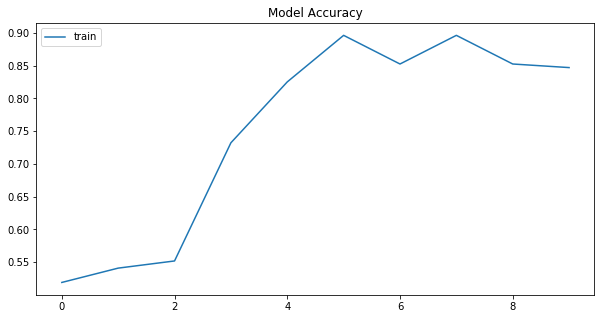

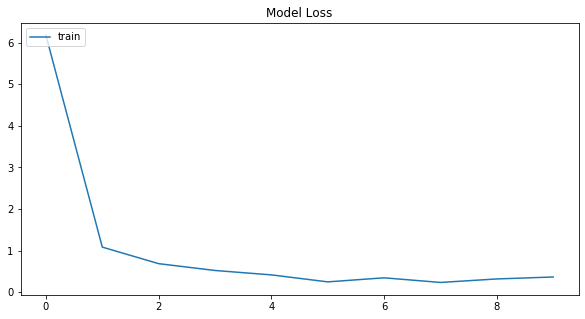

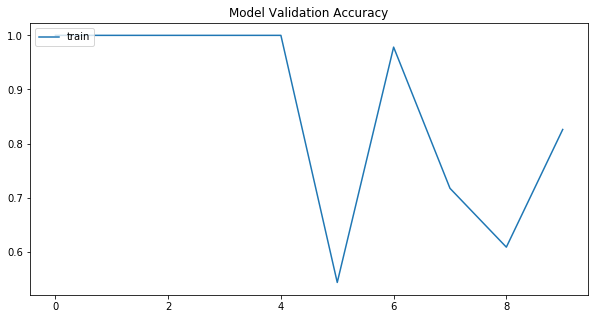

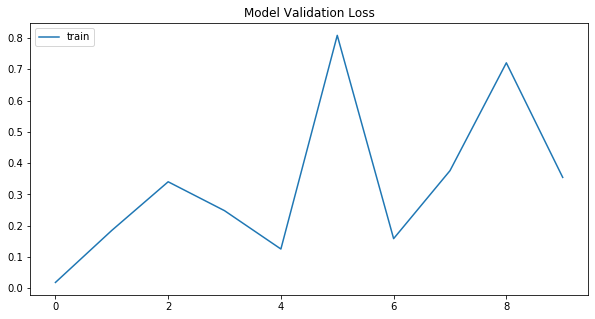

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(vgg_history.epoch, vgg_history.history['accuracy'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(vgg_history.epoch, vgg_history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(vgg_history.epoch, vgg_history.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(vgg_history.epoch, vgg_history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [24]:
vgg_pred = vgg.predict(X_vggtest)
vgg_pred = np.argmax(vgg_pred,axis = 1) 
y_true = np.argmax(y_vggtest,axis = 1)

In [25]:
print(classification_report(y_true,vgg_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       390
           1       0.77      0.65      0.71       234

    accuracy                           0.80       624
   macro avg       0.79      0.77      0.78       624
weighted avg       0.79      0.80      0.79       624



### Plotting the confusion matrix and classification report for VGG-16 classification model handling imbalance
#### For evaluating the performance of the model

The confusion matrix gives us the total number of:
1. True Positive(TP): 344 correct predictions of pneumonia images.
2. False Negative(FN): 46 pneumonia images falsely identified as normal.
3. False Positive(FP): 81 normal images incorrectly identified as pneumonia images.
4. True Negative(TN): 153 normal images correctly identified.

The overall F1-Score: 0.792

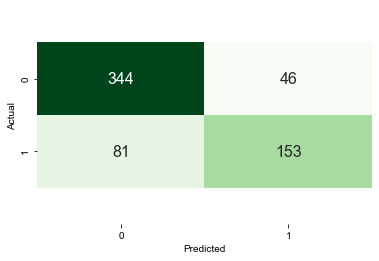

F1-Score: 
0.792618909307301


In [26]:
cm = confusion_matrix(y_true,vgg_pred)
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("F1-Score: ")
print(f1_score(y_true, vgg_pred, average='weighted'))

#### Comparing the performance of models

The dataset is an imbalanced data set where normal chest-xrays are majority class and pneumonia chest-xrays are the minority class.

As an evaluation measure I have considered the weighted average F1-Score for evaluating performance of models.

Weighted average of F1 score gives F1 score for each class independently and weights the F1-score of each class by the number of samples from that class. So I've compared all the models with weighted avg F1 score.

When we have a data imbalance between classes, we should preferably choose F1-score because ROC calculates the average over all thresholds. The ROC curve does not evaluate the performance well for a classifier when data is imbalanced, therefore using  weighted average F1 score for evaluation.

Based on the evaluation results of all the models above, weighted average F1 score of Logistic Regression is the highest for this data set with the score of 0.806. This means that model is 80.6% accurate. The worst performace weighted average F1 score is seen with Data Augmentation CNN model with score of 0.679.

Logistic regression is a very powerful algorithm, even for very complex problems it may do a good job.
Logistic regression and neural networks are closely related. Basically, we can think of logistic regression as a simple 1-layer neural network. It is a widely used technique because it is very efficient, does not require too many computational resources, it’s highly interpretable, it doesn’t require input features to be scaled, it doesn’t require any tuning, it’s easy to regularize, and it outputs well-calibrated predicted probabilities.
